In [50]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [51]:
import os
import numpy as np

import xarray as xr
import intake

import config
import regrid_tools
import util

In [52]:
cat = intake.open_catalog("catalogs/fluxes-catalog-web.yml")
print(cat.yaml())

sources:
  fluxes-catalog-web:
    args:
      path: catalogs/fluxes-catalog-web.yml
    description: Flux datasets
    driver: intake.catalog.local.YAMLFileCatalog
    metadata: {}



In [53]:
version = "v2018"
yr1, yr2 = 2009, 2018

In [54]:
ds = cat[f"fgco2_MPI_SOM_FFN_{version}"].to_dask().compute()            
ds

<xarray.Dataset>
Dimensions:         (time: 432, lat: 180, lon: 360, bnds: 2)
Coordinates:
  * time            (time) datetime64[ns] 1982-01-15 1982-02-15 ... 2017-12-15
  * lat             (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon             (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
Dimensions without coordinates: bnds
Data variables: (12/14)
    spco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    fgco2_raw       (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    spco2_smoothed  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    fgco2_smoothed  (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    sol             (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    kw              (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    ...              ...
    dco2_raw        (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    dco2_smoothed   (time, lat, lon) float32 nan nan nan nan ... nan nan nan nan
    seamask         (lat, lon) int32 0 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0 0
    time_bnds       (time, bnds) datetime64[ns] 1981-12-31 ... 2017-12-31
    lat_bnds        (lat, bnds) float32 -90.0 -89.0 -89.0 ... 89.0 89.0 90.0
    lon_bnds        (lon, bnds) float32 -180.0 -179.0 -179.0 ... 179.0 180.0
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2018
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2019-03-21

In [55]:
time, time_bnds = util.gen_midmonth_cftime_coord((yr1, yr1), climatology_year_end=yr2)

In [56]:
with xr.set_options(keep_attrs=True):
    ds_mon = ds.sel(time=slice(f'{yr1}', f'{yr2}')).groupby("time.month").mean("time").rename({"month": "time"})

ds_mon = ds_mon[["fgco2_smoothed"]].rename({"fgco2_smoothed": "fgco2"})
del ds_mon.fgco2.attrs['FillValue']

ds_mon["area"] = util.compute_grid_area(ds_mon)
ds_mon["time"] = time
ds_mon[time.attrs['climatology']]= time_bnds
ds_mon.time.encoding["_FillValue"] = None
ds_mon

<xarray.Dataset>
Dimensions:             (time: 12, lat: 180, lon: 360, d2: 2)
Coordinates:
  * lat                 (lat) float32 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float32 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time                (time) object 2009-01-16 12:00:00 ... 2009-12-16 12:0...
Dimensions without coordinates: d2
Data variables:
    fgco2               (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    area                (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
    climatology_bounds  (time, d2) object 2009-01-01 00:00:00 ... 2018-01-01 ...
Attributes:
    institution:    MPI-MET, Hamburg, Germany (former: ETH Zurich, Switzerland)
    institude_id:   MPI
    model_id:       SOM-FFN
    run_id:         v2018
    contact:        Peter Landschutzer (peter.landschuetzer@mpimet.mpg.de)
    creation_date:  2019-03-21

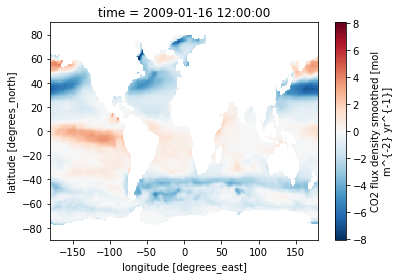

In [57]:
ds_mon.fgco2.isel(time=0).plot()

In [58]:
dso_grid = util.generate_latlon_grid(**config.config_dict["flux-dst-grid-kwargs"])[["area"]]

dso = ds_mon.copy()
dso['lat'] = dso_grid.lat
dso['lon'] = dso_grid.lon
dso['area'] = dso_grid.area
dso.attrs = {}
dso

<xarray.Dataset>
Dimensions:             (time: 12, lat: 180, lon: 360, d2: 2)
Coordinates:
  * lat                 (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
  * lon                 (lon) float64 -179.5 -178.5 -177.5 ... 177.5 178.5 179.5
  * time                (time) object 2009-01-16 12:00:00 ... 2009-12-16 12:0...
Dimensions without coordinates: d2
Data variables:
    fgco2               (time, lat, lon) float32 nan nan nan nan ... nan nan nan
    area                (lat, lon) float64 1.079e+08 1.079e+08 ... 1.079e+08
    climatology_bounds  (time, d2) object 2009-01-01 00:00:00 ... 2018-01-01 ...

In [59]:
file_out = f"{config.flux_product_dir}/fgco2.MPI-SOM-FFN.{version}.monclim_{yr1}-{yr2}.nc"

dso.attrs['source'] = f'monthly climatatology of MPI-SOM-FFN.{version} CO2 fluxes'
util.to_netcdf_clean(dso, file_out)

------------------------------
Writing /glade/work/mclong/sno-analysis/flux-products/fgco2.MPI-SOM-FFN.v2018.monclim_2009-2018.nc
netcdf fgco2.MPI-SOM-FFN.v2018.monclim_2009-2018 {
dimensions:
	time = 12 ;
	lat = 180 ;
	lon = 360 ;
	d2 = 2 ;
variables:
	float fgco2(time, lat, lon) ;
		fgco2:_FillValue = 9.96921e+36f ;
		fgco2:long_name = "CO2 flux density smoothed" ;
		fgco2:standard_name = "CO2 flux density smoothed" ;
		fgco2:units = "mol m^{-2} yr^{-1}" ;
	double lat(lat) ;
		lat:units = "degrees_north" ;
		lat:long_name = "Latitude" ;
	double lon(lon) ;
		lon:units = "degrees_east" ;
		lon:long_name = "Longitude" ;
	double time(time) ;
		time:shift_time = 0. ;
		time:climatology = "climatology_bounds" ;
		time:units = "days since 2009-01-01" ;
		time:calendar = "gregorian" ;
	float area(lat, lon) ;
		area:_FillValue = 9.96921e+36f ;
		area:units = "m^2" ;
		area:long_name = "area" ;
	double climatology_bounds(time, d2) ;
		climatology_bounds:units = "days since 2009-01-01 00:00:00.

In [60]:
curator = util.curate_flux_products()
curator.add_source(
        key=f"fgco2.MPI-SOM-FFN",
        urlpath=file_out,
        description=cat[f"fgco2_MPI_SOM_FFN_{version}"].description,
    )